### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [2]:
# !pip install nltk

In [3]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import SnowballStemmer

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
df = pd.read_csv('./6.csv')
df.head(5)

,doc_text,image2text,speech2text
0,Отправь своему пузатику 🤣 #прикол #шутка # с...,мой муж супер зажиточный прошк just «мати арис...,"мой муж супер зажидочный аристократ, у него на..."
1,Дачный вайб 😂🐶🐓👶 P.s Ни одно животное при съе...,NaN,До новых встреч!
2,Голосовое сообщение,NaN,"Вот все пишут мне, что сейчас я урод, а в 2016..."
3,У меня дома лежат два коврика для йоги. Занима...,йога с м ' ужем,Я не могу заниматься йогой рядом с мужем. Как ...
4,"Когда забыли, зачем собирались 🤷🏼‍♂️ #дедищев ...",g r 9 crew,"Помните вот этот момент, народ, когда поминки ..."


### Предварительный анализ датасета

In [6]:
print(f'Размер набора данных:')
print(f'Число строк: {len(df)}, Число столбцов: {len(df.columns)}')
for col in df.columns:
    print(f'{col}: {len(df[col].unique())} уникальных значений.')

Размер набора данных:
Число строк: 1000, Число столбцов: 3
doc_text: 892 уникальных значений.
image2text: 592 уникальных значений.
speech2text: 584 уникальных значений.


In [7]:
df.describe(include='all')

,doc_text,image2text,speech2text
count,1000,613,596
unique,892,591,583
top,ПОЛНЫЕ ВЫПУСКИ В ШАПКЕ ПРОФИЛЯ☝🏻 Мария Маркова...,1,До новых встреч!
freq,58,3,3


In [8]:
print(df.dtypes)

doc_text       object
image2text     object
speech2text    object
dtype: object


In [9]:
missing_values = df.isnull().sum()
print('Количество NULL`ов (строк)')
print(missing_values[missing_values > 0])
print()

percent_missing = missing_values / len(df) * 100
print('Количество NULL`ов (%)')
print(percent_missing)

Количество NULL`ов (строк)
image2text     387
speech2text    404
dtype: int64

Количество NULL`ов (%)
doc_text        0.0
image2text     38.7
speech2text    40.4
dtype: float64


In [10]:
for col in df.columns:
    print(f'{col}: {len(df[col].unique())} уникальных значений.')

doc_text: 892 уникальных значений.
image2text: 592 уникальных значений.
speech2text: 584 уникальных значений.


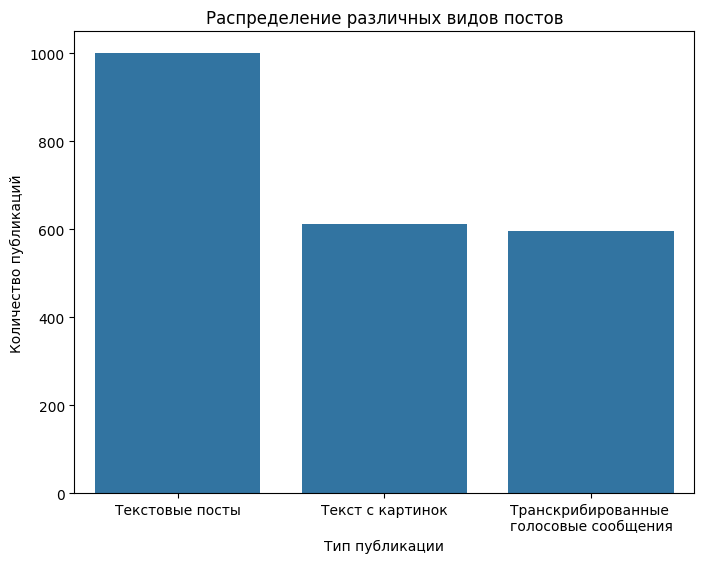

In [11]:
post_counts = {
    'Текстовые посты': len(df['doc_text'].dropna()),
    'Текст с картинок': len(df['image2text'].dropna()),
    'Транскрибированные \nголосовые сообщения': len(df['speech2text'].dropna())
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(post_counts.keys()), y=list(post_counts.values()))
plt.xlabel("Тип публикации")
plt.ylabel("Количество публикаций")
plt.title("Распределение различных видов постов")
plt.show()

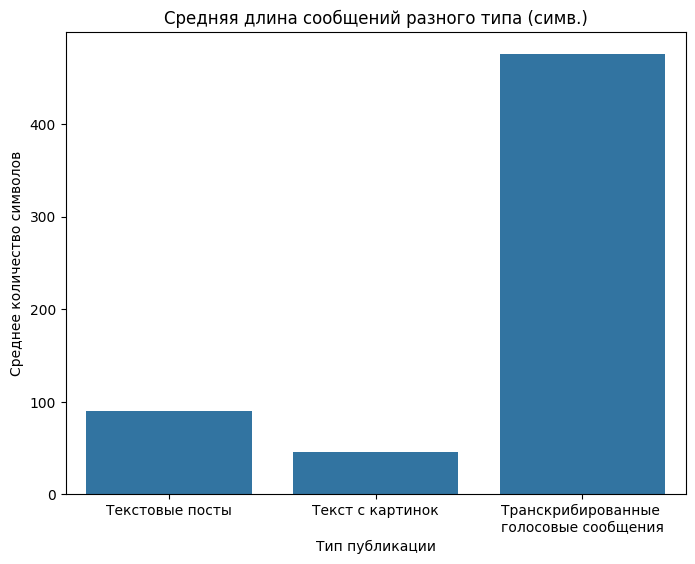

In [12]:
def avg_length(text_series):
    return text_series.str.len().mean()

avg_lengths = {
    'Текстовые посты': avg_length(df['doc_text']),
    'Текст с картинок': avg_length(df['image2text']),
    'Транскрибированные \nголосовые сообщения': avg_length(df['speech2text'])
}

plt.figure(figsize=(8, 6))
sns.barplot(x=list(avg_lengths.keys()), y=list(avg_lengths.values()))
plt.xlabel("Тип публикации")
plt.ylabel("Среднее количество символов")
plt.title("Средняя длина сообщений разного типа (симв.)")
plt.show()

In [13]:
print('Кросс-таблица наполнения записи:')
print('Текст + картинка + голосовое:')
cross_tab = pd.crosstab(
    index=df['doc_text'].isna(),
    columns=[
        df['image2text'].isna(),
        df['speech2text'].isna()
    ]
)

cross_tab

Кросс-таблица наполнения записи:
Текст + картинка + голосовое:


image2text  False       True       
speech2text False True  False True 
doc_text                           
False         412   201   184   203

### Очистка текстов в датасете

In [14]:
# df = pd.read_csv('./1.csv')
# Загрузка стоп-слов русского языка
stop_words = set(stopwords.words('russian')) | set(stopwords.words('english'))
for stop_word in ['это', 'п', 'м', 'th', 'tht']:
    stop_words.add(stop_word)


# Очищаем данные от цифр
def remove_numbers(df):
    """
    Функция удаляет числовые значения из всех текстовых колонок датасета.
    """
    # В цикле по всем колонкам
    for col in df.columns:
        # Обрабатываем текстовые
        if df[col].dtype == 'object':
            # Заменяем цифры на пустое значение
            df[col] = df[col].apply(lambda x: re.sub(r'\d+', '', str(x)).strip())
            
    return df

df = remove_numbers(df)

# Обрабатываем текст в дата-сете
def preprocess_text(text):
    """
    Функция функция очищает текст от различных символов.
    """    
    # Приводим текст к нижнему регистру
    text = text.lower()

    # Удаляем ссылки, знаки препинания, эмодзи, небуквенные символы, html-теги, пробелы
    text = re.sub(r'(https|http)\S*', '', str(text))
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^а-яА-ЯёЁйЙa-zA-Z\s]', '', text)
    text = text.strip()
    
    # Токенизируем строки
    tokens = word_tokenize(text)
    
    # Удаляем стоп-слова
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(filtered_tokens)

# Применяем обработку ко всем текстовым столбцам
for col in ['doc_text', 'image2text', 'speech2text']:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(preprocess_text)

In [15]:
for col in df.columns:
    print(f'{col}: {len(df[col].unique())} уникальных значений после обработки.')

doc_text: 834 уникальных значений после обработки.
image2text: 539 уникальных значений после обработки.
speech2text: 579 уникальных значений после обработки.


In [16]:
duplicates = df.duplicated().sum()
print(f'Общее число дубликатов: {duplicates}')

Общее число дубликатов: 34


### Анализ текстов в датасете после очистки.

In [17]:
# Функция для подсчета топ-слов
def top_words(text_series, n=10):
    """
    Функция возвращает самые часто встречаемые слова в тексте
    """
    words = []
    for row in text_series.dropna():
        words.extend(row.split())
    word_count = Counter(words)
    return dict(word_count.most_common(n))

top_doc_words = top_words(df['doc_text'])
top_image_words = top_words(df['image2text'].where(df['image2text'] != 'nan').dropna())
top_speech_words = top_words(df['speech2text'].where(df['speech2text'] != 'nan').dropna())

print("Топ-слова в текстовых постах:")
print(top_doc_words)

print("\nТоп-слова в тексте с картинок:")
print(top_image_words)

print("\nТоп-слова в транскрибированных голосовых сообщениях:")
print(top_speech_words)

Топ-слова в текстовых постах:
{'стендап': 623, 'женский': 286, 'тнт': 120, 'маркова': 116, 'юмор': 107, 'камеди': 79, 'натнт': 78, 'сезон': 67, 'шапке': 66, 'профиля': 65}

Топ-слова в тексте с картинок:
{'видео': 19, 'v': 15, 'l': 14, 'вообще': 14, 'vк': 12, 'лет': 12, 'х': 12, 'г': 12, 'тебе': 11, 'т': 11}

Топ-слова в транскрибированных голосовых сообщениях:
{'просто': 206, 'вообще': 203, 'говорит': 147, 'думаю': 124, 'очень': 122, 'всё': 105, 'тебе': 103, 'говорю': 101, 'типа': 97, 'такая': 96}


In [18]:
# Создаем векторизатор TF-IDF
vectorizer = TfidfVectorizer()

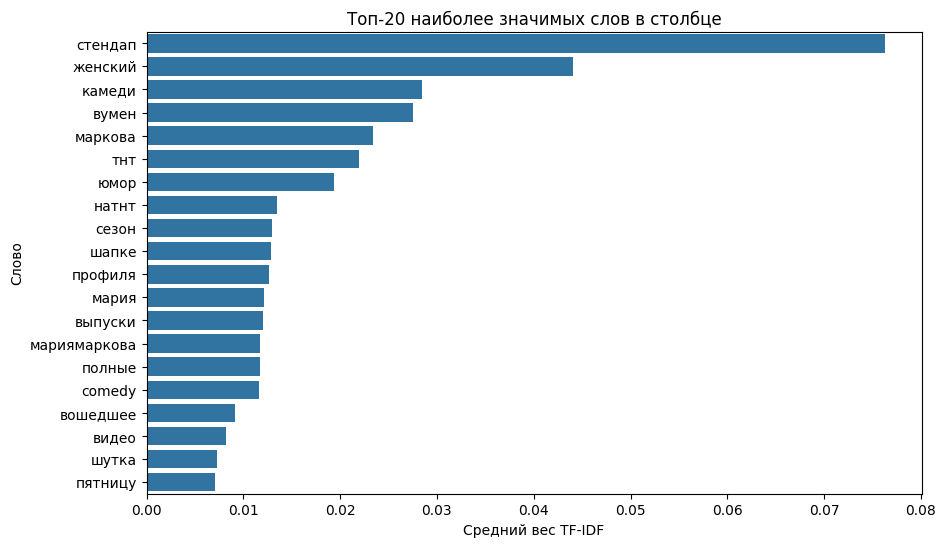

In [19]:
X_tfidf = vectorizer.fit_transform(df['doc_text'])

# Преобразуем матрицу TF-IDF в DataFrame
# Список уникальных слов
feature_names = vectorizer.get_feature_names_out()  
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

mean_tfidf_scores = df_tfidf.mean(axis=0)
sorted_mean_tfidf = mean_tfidf_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=sorted_mean_tfidf.index[:20], x=sorted_mean_tfidf.values[:20])
plt.ylabel("Слово")
plt.xlabel("Средний вес TF-IDF")
plt.title("Топ-20 наиболее значимых слов в столбце")
plt.show()

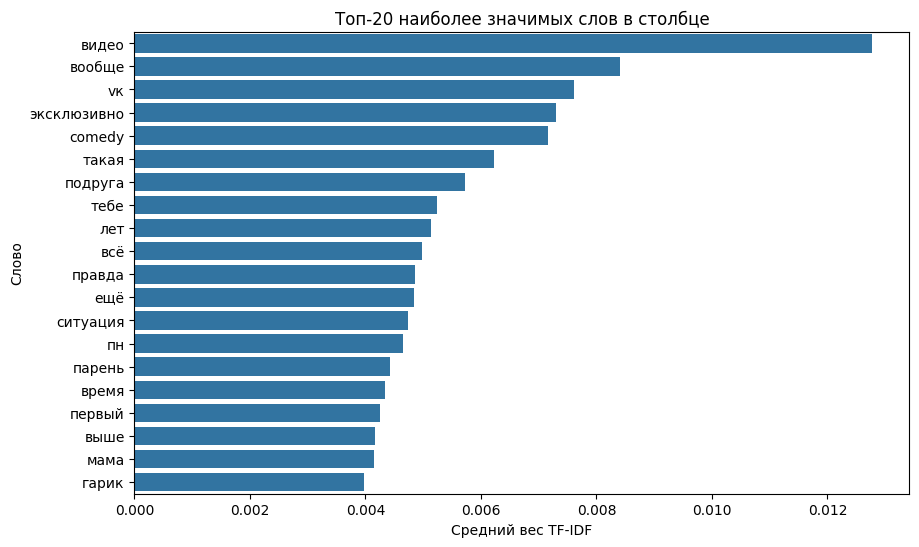

In [20]:
X_tfidf = vectorizer.fit_transform(df['image2text'].where(df['image2text'] != 'nan').dropna())

# Преобразуем матрицу TF-IDF в DataFrame
# Список уникальных слов
feature_names = vectorizer.get_feature_names_out()  
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

mean_tfidf_scores = df_tfidf.mean(axis=0)
sorted_mean_tfidf = mean_tfidf_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=sorted_mean_tfidf.index[:20], x=sorted_mean_tfidf.values[:20])
plt.ylabel("Слово")
plt.xlabel("Средний вес TF-IDF")
plt.title("Топ-20 наиболее значимых слов в столбце")
plt.show()

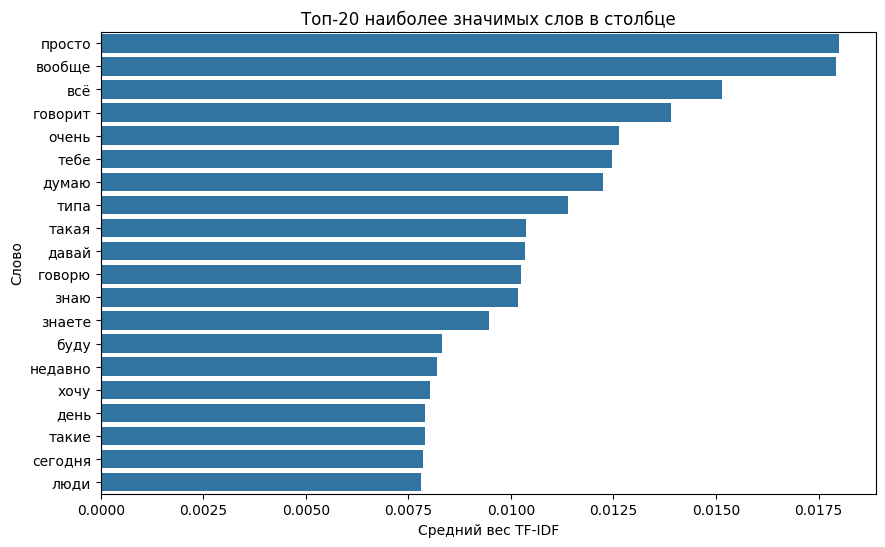

In [21]:
X_tfidf = vectorizer.fit_transform(df['speech2text'].where(df['speech2text'] != 'nan').dropna())

# Преобразуем матрицу TF-IDF в DataFrame
# Список уникальных слов
feature_names = vectorizer.get_feature_names_out()  
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=feature_names)

mean_tfidf_scores = df_tfidf.mean(axis=0)
sorted_mean_tfidf = mean_tfidf_scores.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y=sorted_mean_tfidf.index[:20], x=sorted_mean_tfidf.values[:20])
plt.ylabel("Слово")
plt.xlabel("Средний вес TF-IDF")
plt.title("Топ-20 наиболее значимых слов в столбце")
plt.show()